##### Import all the necessary libraries

In [2]:
# import all the necessary libraries

# use tensorflow to load the data and to build the models
import tensorflow as tf

from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
from tensorflow.keras.applications import ResNet50, VGG19, DenseNet121,EfficientNetB0
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
import hpelm
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score



##### Load the data

In [4]:
# load the image data to perform classification

# set image size in terms of width and height for the images 
IMAGE_SIZE = (512,384)
# set the batch size to define the number of images to process in one batch
BATCH_SIZE = 32

# use 'tensorflow.keras' function to load the images from the directory
# set the parameters, define the directory name, image_size, batch_size
# set 'shuffle = True' to improve generalization. 
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Garbage classification",
    shuffle=True,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)


Found 2527 files belonging to 6 classes.


##### EDA - Exploratory Data Analysis

In [6]:
# use 'len()' function to print the length of the dataset
print("Length of the dataset is : ",len(dataset))

# use '.class_names' attribute of function 'image_dataset_from_directory' to print the names of all labels
class_names = dataset.class_names
print("Labels in the dataset : ",class_names)

Length of the dataset is :  79
Labels in the dataset :  ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


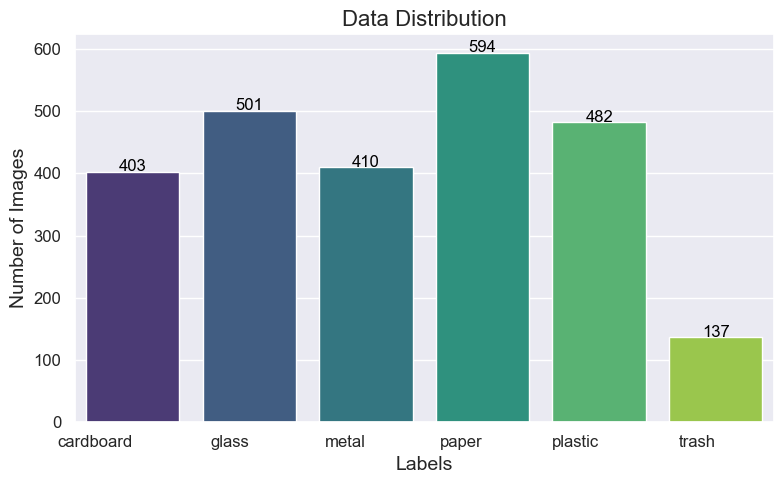

In [7]:
# data distribution
# use 'counter()' from the collection module to count the occurences of each class
class_count = Counter()

# use 'for' loop to iterate over the dataset  to count the number of images in each class 
for images, labels in dataset:
    # update the initialised counter with the labels
    class_count.update(labels.numpy())

# create a list named 'counts' and store the counts corresponding to each class_names
counts = [class_count[i] for i in range(len(class_names))]

# use 'Seaborn' library to create a bar plot for visualizing the distribution of data for each label
# generate the bar plot with class names on x-axis and counts on y-axis
# Set the style of the visualization
sns.set(style="darkgrid")

# Create the plot
plt.figure(figsize=(8, 5))
barplot = sns.barplot(x=class_names, y=counts, hue=class_names, palette='viridis', dodge=False, legend=False)

# Add titles and labels
plt.title('Data Distribution', fontsize=16)
plt.xlabel('Labels', fontsize=14)
plt.ylabel('Number of Images', fontsize=14)

# Customize the x-axis labels
plt.xticks( ha='right', fontsize=12)
plt.yticks(fontsize=12)

# Annotate the bars with the counts
for i in range(len(counts)):
    barplot.text(i, counts[i] + 0.5, counts[i], ha='center', fontsize=12, color='black')

# Display the plot
plt.tight_layout()
plt.show()


In [8]:
# use '.take()' method to get the first batch of data
# print the shape of images from the batch 1
# print all the labels present in batch 1
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 512, 384, 3)
[2 1 0 0 1 1 3 3 0 2 1 5 2 2 4 3 2 2 1 1 1 3 4 3 3 0 1 4 1 2 0 4]


In [9]:
# print the numpy array of the image data
# '.numpy()' method converts the tensor into numpy array
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].numpy())

[[[240.      251.      255.     ]
  [240.      251.      255.     ]
  [240.      251.      255.     ]
  ...
  [210.      213.      218.     ]
  [210.      213.      218.     ]
  [209.16666 212.16666 217.16666]]

 [[239.375   250.375   254.375  ]
  [239.375   250.375   254.375  ]
  [239.375   250.375   254.375  ]
  ...
  [210.      213.      218.     ]
  [210.      213.      218.     ]
  [209.16666 212.16666 217.16666]]

 [[239.      250.      254.     ]
  [239.      250.      254.     ]
  [239.      250.      254.     ]
  ...
  [210.      213.      218.     ]
  [210.      213.      218.     ]
  [209.16666 212.16666 217.16666]]

 ...

 [[237.83333 243.83333 243.83333]
  [237.      243.      243.     ]
  [237.      243.      243.     ]
  ...
  [189.      194.      197.     ]
  [189.      194.      197.     ]
  [188.16666 193.16666 196.16666]]

 [[237.83333 243.83333 243.83333]
  [237.      243.      243.     ]
  [237.      243.      243.     ]
  ...
  [189.      194.      197.     ]
  [1

In [10]:
# print the image size
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].shape)

(512, 384, 3)


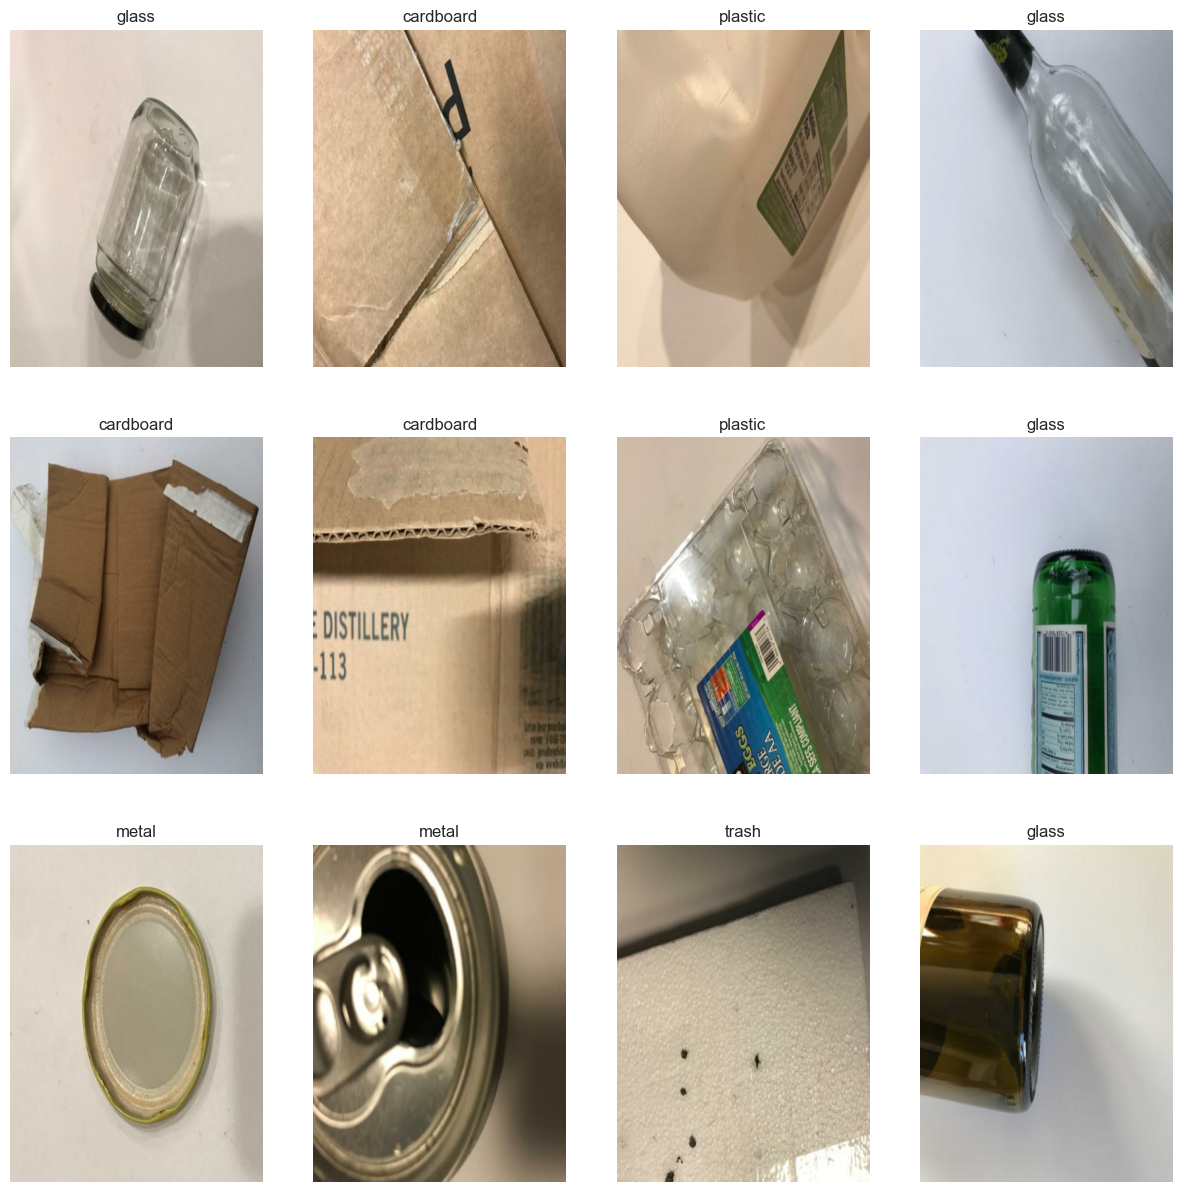

In [11]:
# displaying few images from the first batch dataset

# set the figure size
plt.figure(figsize=(15,15))

# iterate over the images using 'for' loop and display them
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
        

##### Split the data into train, test and validation

In [13]:
# create a function to split the data into train (80%), validate (10%) and test (10%)
def get_dataset_partitions_tf(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):

    """ 
    function to split the data into train, validate and test based on given proportion
    dataset, train_proportion, val_proportion, test_proportion, shuffle, and shuffle_size were passes as parameters
    return the training subset, validation subset and testing subset of dataset
    """

    # get the length of dataset
    ds_size = len(ds)
    # check condition: shuffle the dataset if shuffle is True 
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)

    # calculate the length of train_dataset
    train_size = int(train_split * ds_size)
    # calculate the length of validation_dataset
    val_size = int(val_split * ds_size)
    
    # get the data equal to the size using '.take' method
    train_ds = ds.take(train_size)
    # use '.skip()' method to skip the train_length and then use '.take()' to get the data for validation
    val_ds = ds.skip(train_size).take(val_size)
    # skip the train_length and val_length and the remaining data is the test data
    test_ds = ds.skip(train_size).skip(val_size)

    # return the train_ds, val_ds and test_ds
    return train_ds, val_ds, test_ds

In [14]:
# call the function 'get_dataset_partitions_tf' and store the value in varoiable 'train_dataset', 'val_dataset' and 'test_dataset'
train_dataset, val_dataset, test_dataset = get_dataset_partitions_tf(dataset)

In [15]:
# print the length of train, val and test dataset
print("Length of training dataset:",len(train_dataset))
print("Length of validation dataset:",len(val_dataset))
print("Length of test dataset:",len(test_dataset))

Length of training dataset: 63
Length of validation dataset: 7
Length of test dataset: 9


In [16]:

# Function to count the number of images in each class label 
def get_class_counts(dataset):
    """
    function counts the number of images for each class labels
    dataset was passes as the parameter
    returns a list of counts corresponding to each label
    """
    # initialise the counter() to count the occurences
    class_count = Counter()
    for images, labels in dataset:
        class_count.update(labels.numpy())
    return [class_count[i] for i in range(len(class_names))]

# call the function 'get_class_counts' and get the counts for each dataset
train_counts = get_class_counts(train_dataset)
val_counts = get_class_counts(val_dataset)
test_counts = get_class_counts(test_dataset)

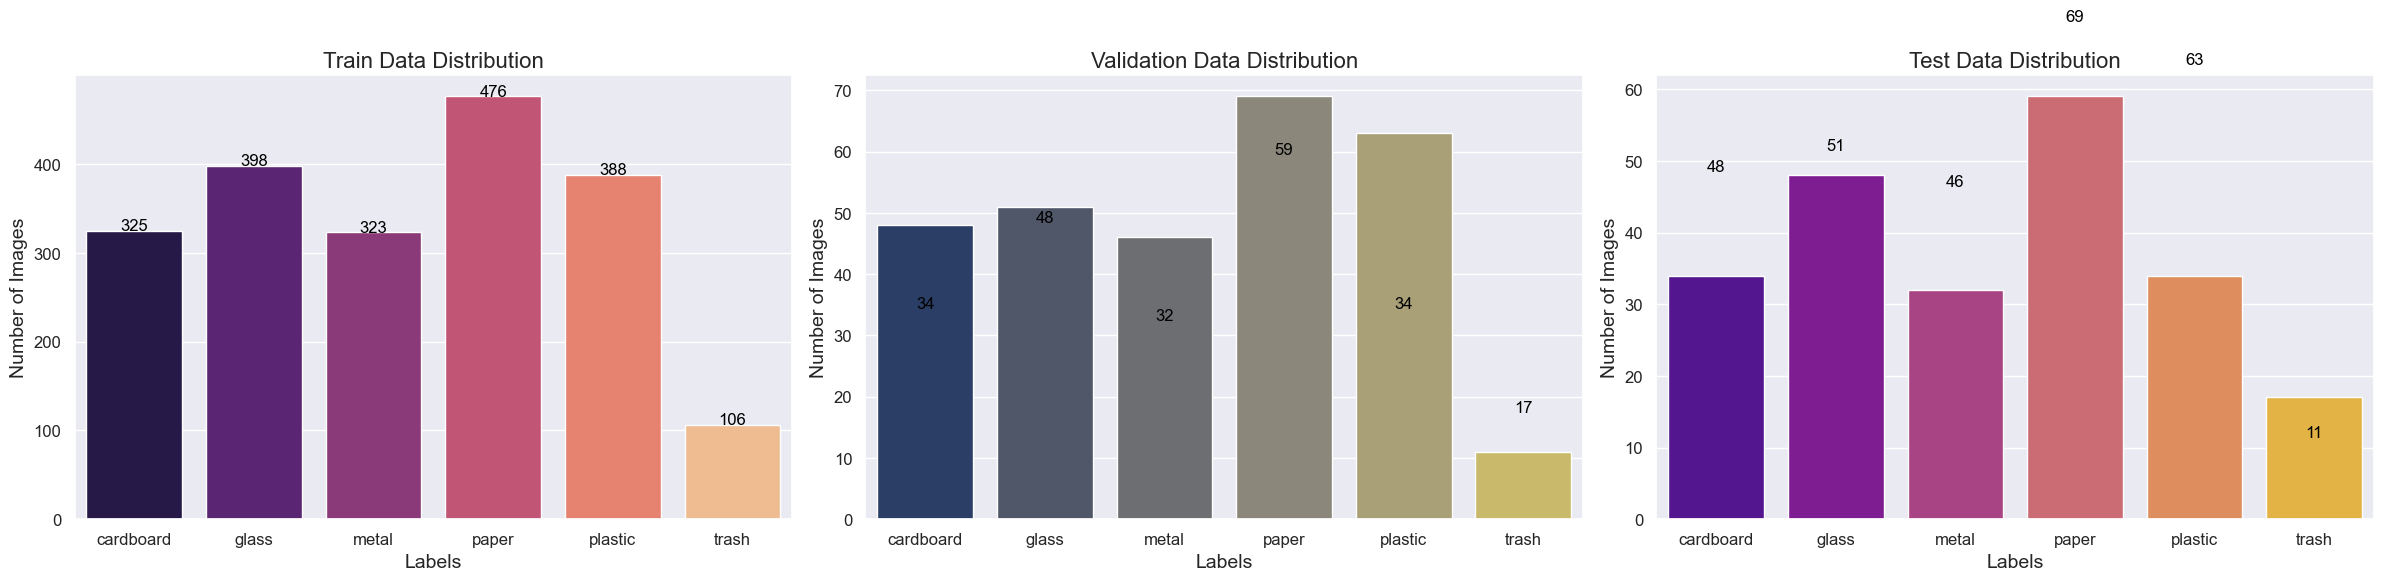

In [17]:
# display the distribution for each subset

# Set the style of the visualization
sns.set(style="darkgrid")

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

# Plot for train dataset
sns.barplot(x=class_names, y=train_counts, hue=class_names, palette='magma', ax=axes[0])
axes[0].set_title('Train Data Distribution', fontsize=16)
axes[0].set_xlabel('Labels', fontsize=14)
axes[0].set_ylabel('Number of Images', fontsize=14)
axes[0].tick_params(axis='x', labelsize=12)
axes[0].tick_params(axis='y', labelsize=12)
for i in range(len(train_counts)):
    axes[0].text(i, train_counts[i] + 0.5, train_counts[i], ha='center', fontsize=12, color='black')


# Plot for validation dataset
sns.barplot(x=class_names, y=val_counts,hue=class_names,  palette='plasma', ax=axes[2])
axes[1].set_title('Validation Data Distribution', fontsize=16)
axes[1].set_xlabel('Labels', fontsize=14)
axes[1].set_ylabel('Number of Images', fontsize=14)
axes[1].tick_params(axis='x', labelsize=12)
axes[1].tick_params(axis='y', labelsize=12)
for i in range(len(val_counts)):
    axes[1].text(i, val_counts[i] + 0.5, val_counts[i], ha='center', fontsize=12, color='black')

# Plot for test dataset
sns.barplot(x=class_names, y=test_counts, hue=class_names, palette='cividis', ax=axes[1])
axes[2].set_title('Test Data Distribution', fontsize=16)
axes[2].set_xlabel('Labels', fontsize=14)
axes[2].set_ylabel('Number of Images', fontsize=14)
axes[2].tick_params(axis='x',  labelsize=12)
axes[2].tick_params(axis='y', labelsize=12)
for i in range(len(test_counts)):
    axes[2].text(i, test_counts[i] + 0.5, test_counts[i], ha='center', fontsize=12, color='black')

# Display the plots
plt.tight_layout()
plt.show()

In [18]:
# Apply caching and prefetching to optimize the performance of the TensorFlow datasets
train_dataset = train_dataset.cache().prefetch(buffer_size = tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size = tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size = tf.data.AUTOTUNE)

##### Pre-Processing

In [20]:
# Define a data preprocessing pipeline for resizing and rescaling images
# Resize all images to 224x224 pixels
# Scale pixel values from [0, 255] to [0, 1]

resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(224,224),
    layers.Rescaling(1.0/255)
])

In [21]:
# Apply the preprocessing pipeline to the training, validation and test dataset
train_dataset = train_dataset.map(lambda x, y: (resize_and_rescale(x), y))
val_dataset = val_dataset.map(lambda x, y: (resize_and_rescale(x), y))
test_dataset = test_dataset.map(lambda x, y: (resize_and_rescale(x), y))

##### Data Augmentation

In [23]:
# Define a data augmentation pipeline
# use 'RandomFlip()' to randomly flip images horizontally and vertically
# use 'RandomRotation()' to randomly rotate images by up to 20% of 360 degreescally which is 72 degrees

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),

])

In [24]:
# Apply the data augmentation pipeline to only training dataset
augmented_train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x), y))


##### Function to create feature extractor base model

In [26]:
def create_model(model_name):
    """
    the function creates a feature extractor model with the specified model\
    the model name is passed as a parameter
    returns the created feature extractor model
    """
    # load the base model with pre-trained ImageNet weights, excluding the top classification layer
    base_model = model_name(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    # freeze the base model to prevent its weights from being updated during training
    base_model.trainable = False
    # define the input layer of model
    inputs = layers.Input(shape=(224,224,3))
    # pass the inputs through the base model
    x = base_model(inputs, training = False)
    # apply global average pooliong layer to convert the feature map into 1D vector
    x = layers.GlobalAveragePooling2D()(x)
    # create the model
    feature_extractor = Model(inputs,x)
    # return the created feature_extractor model
    return feature_extractor

##### Function to extract features

In [28]:
# Extract features from the datasets
def extract_features(dataset, feature_extractor):
    
    """
    extract featutres from images in the dataset using feature extractor model
    dataset and the feature extractor model are passed as parameters
    return an array of extracted features and array of corresponding labels
    """
    # define two lists, one to store extracted features and another for labels for the images
    features = []
    labels = []
    # iterate over the images
    for images, batch_labels in dataset:
       # use '.predict()' to extract the features  
       batch_features = feature_extractor.predict(images)
       features.append(batch_features)
       labels.append(batch_labels)
    return np.concatenate(features), np.concatenate(labels)

##### Function for encoding labels

In [30]:
def one_hot_encode_labels(train_labels, val_labels, test_labels):
    """ 
    function performs the one-hot encoding for the labels
    train_labels, val_labels and test_labels are passed as parameters
    returns the encoded and reshaped labels for each subset
    """
    # Reshape the labels
    y_train_encoded = train_labels.reshape(-1, 1)
    y_val_encoded = val_labels.reshape(-1, 1)
    y_test_encoded = test_labels.reshape(-1, 1)
    
    # Initialize the OneHotEncoder
    onehot_encoder = OneHotEncoder(sparse_output=False)
    
    # Fit the encoder on the training labels and transform all label sets
    y_train_onehot = onehot_encoder.fit_transform(y_train_encoded)
    y_val_onehot = onehot_encoder.fit_transform(y_val_encoded)
    y_test_onehot = onehot_encoder.transform(y_test_encoded)
    
    return y_train_encoded, y_val_encoded, y_test_encoded, y_train_onehot, y_val_onehot, y_test_onehot

In [31]:
# initialize the standard scaler 
scaler = StandardScaler()

##### Function to create elm model

In [33]:
def create_ELM(input, output, neurons, activation_function):
    """
    function creates an ELM model with specified parameters
    input, output , number of neurons and sactivation function are passed as parameters
    return the created ELM model
    """
    # use 'hpelm' library to create the ELM model for classification
    elm = hpelm.ELM(input, output, classification = "c")
    # add the specified and optimized number of neurons to the created model 
    elm.add_neurons(neurons, activation_function)
    return elm

### WITHOUT AUGMENTATION

#### MODEL 1: RESNET50-ELM

In [36]:
# create the feature extraction model with ResNet50 as base model
resnet = create_model(ResNet50)

In [37]:
# print the summary of model
resnet.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [38]:
# use 'extract_features' function to extract the features and corresponding labeles for each subset
resnet_train_features, resnet_train_labels = extract_features(train_dataset, resnet)
resnet_val_features, resnet_val_labels = extract_features(val_dataset, resnet)
resnet_test_features, resnet_test_labels = extract_features(test_dataset, resnet)

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 

In [39]:
# print the shape of features for each subset
print("Train features shape:", resnet_train_features.shape)
print("Validation features shape:", resnet_val_features.shape)
print("Test features shape:", resnet_test_features.shape)

Train features shape: (2015, 2048)
Validation features shape: (224, 2048)
Test features shape: (288, 2048)


In [40]:
# standardize the extracted features
resnet_train_scaled = scaler.fit_transform(resnet_train_features)
resnet_val_scaled = scaler.fit_transform(resnet_val_features)
resnet_test_scaled = scaler.transform(resnet_test_features)

In [41]:
# perform one-hot encoding for labels
resnet_train_encoded, resnet_val_encoded ,resnet_test_encoded, resnet_train_onehot, resnet_val_onehot, resnet_test_onehot = one_hot_encode_labels(resnet_train_labels, resnet_val_labels, resnet_test_labels)


In [42]:
# create the ELM model for resnet features
resnet_elm = create_ELM(resnet_train_scaled.shape[1], resnet_train_onehot.shape[1], 1000, "tanh")
# train the model using 'hpelm.mss_v.train_v' - the function finds the optimized number of neurons for the model 
hpelm.mss_v.train_v(resnet_elm, resnet_train_scaled, resnet_train_onehot, resnet_val_scaled, resnet_val_onehot)

# print the optimal number of neurons used in the model
optimal_neurons = resnet_elm.nnet.L
print("Optimal number of neurons: ", optimal_neurons)

Optimal number of neurons:  750


Test Accuracy: 57.64%
Precision: 58.65%
Recall: 57.64%
F1 Score: 57.43%


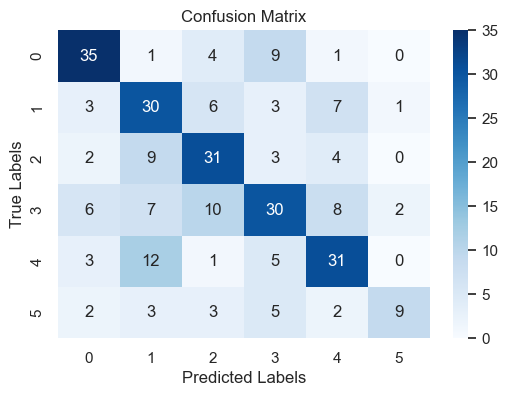

In [43]:
# make predictions using the trained ELM model on the scaled test data
resnet_pred = resnet_elm.predict(resnet_test_scaled)
# use 'np.argmax()' to convert the predictions from one-hot encoded format to class labels
resnet_pred_labels = np.argmax(resnet_pred, axis=1)

# calculate the performance metrics - accuracy, precision, recall, f1 score and confusion matrix
accuracy = accuracy_score(resnet_test_encoded, resnet_pred_labels)
precision = precision_score(resnet_test_encoded, resnet_pred_labels, average='weighted')
recall = recall_score(resnet_test_encoded, resnet_pred_labels, average='weighted')
f1 = f1_score(resnet_test_encoded, resnet_pred_labels, average='weighted')
conf_matrix = confusion_matrix(resnet_test_encoded, resnet_pred_labels)

# print the calculated performance metrics
print("Test Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("F1 Score: {:.2f}%".format(f1 * 100))

# use heatmap to plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

#### MODEL 2: INCEPTION V3-ELM

In [45]:
# create the feature extraction model with InceptionV3 as base model
inception = create_model(InceptionV3)

In [46]:
# print the summary of model
inception.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 5, 5, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,802,784 (83.17 MB)

In [47]:
# use 'extract_features' function to extract the features and corresponding labeles for each subset
inception_train_features, inception_train_labels = extract_features(train_dataset, inception)
inception_val_features, inception_val_labels = extract_features(val_dataset, inception)
inception_test_features, inception_test_labels = extract_features(test_dataset, inception)

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

In [48]:
# print the shape of features for each subset
print("Train features shape:", inception_train_features.shape)
print("Validation features shape:", inception_val_features.shape)
print("Test features shape:", inception_test_features.shape)

Train features shape: (2015, 2048)
Validation features shape: (224, 2048)
Test features shape: (288, 2048)


In [49]:
# standardize the extracted features
inception_train_scaled = scaler.fit_transform(inception_train_features)
inception_val_scaled = scaler.fit_transform(inception_val_features)
inception_test_scaled = scaler.transform(inception_test_features)

In [50]:
# perform one-hot encoding for labels
inception_train_encoded, inception_val_encoded ,inception_test_encoded, inception_train_onehot, inception_val_onehot, inception_test_onehot = one_hot_encode_labels(inception_train_labels, inception_val_labels, inception_test_labels)


In [51]:
# create the ELM model for inception features
inception_elm = create_ELM(inception_train_scaled.shape[1], inception_train_onehot.shape[1], 1000, "tanh")
# train the model using 'hpelm.mss_v.train_v' - the function finds the optimized number of neurons for the model 
hpelm.mss_v.train_v(inception_elm, inception_train_scaled, inception_train_onehot, inception_val_scaled, inception_val_onehot)

# print the optimal number of neurons used in the model
optimal_neurons = inception_elm.nnet.L
print("Optimal number of neurons: ", optimal_neurons)

Optimal number of neurons:  859


Test Accuracy: 93.75%
Precision: 93.77%
Recall: 93.75%
F1 Score: 93.73%


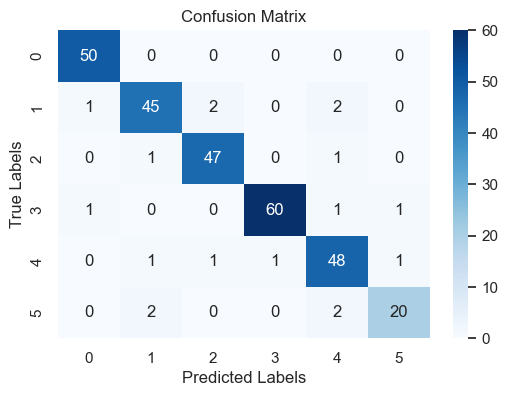

In [52]:
# make predictions using the trained ELM model on the scaled test data
inception_pred = inception_elm.predict(inception_test_scaled)
# use 'np.argmax()' to convert the predictions from one-hot encoded format to class labels
inception_pred_labels = np.argmax(inception_pred, axis=1)

# calculate the performance metrics - accuracy, precision, recall, f1 score and confusion matrix
accuracy = accuracy_score(inception_test_encoded, inception_pred_labels)
precision = precision_score(inception_test_encoded, inception_pred_labels, average='weighted')
recall = recall_score(inception_test_encoded, inception_pred_labels, average='weighted')
f1 = f1_score(inception_test_encoded, inception_pred_labels, average='weighted')
conf_matrix = confusion_matrix(inception_test_encoded, inception_pred_labels)

# print the calculated performance matrix
print("Test Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("F1 Score: {:.2f}%".format(f1 * 100))

# use heatmap to plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

#### MODEL 3 : VGG19-ELM

In [54]:
# create the feature extraction model with VGG19 as base model
vgg19 = create_model(VGG19)

In [55]:
# print the summary of model
vgg19.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,024,384 (76.39 MB)

In [56]:
# use 'extract_features' function to extract the features and corresponding labeles for each subset
vgg19_train_features, vgg19_train_labels = extract_features(train_dataset, vgg19)
vgg19_val_features, vgg19_val_labels = extract_features(val_dataset, vgg19)
vgg19_test_features, vgg19_test_labels = extract_features(test_dataset, vgg19)

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 

In [57]:
# print the shape of features for each subset
print("Train features shape:", vgg19_train_features.shape)
print("Validation features shape:", vgg19_val_features.shape)
print("Test features shape:", vgg19_test_features.shape)

Train features shape: (2015, 512)
Validation features shape: (224, 512)
Test features shape: (288, 512)


In [58]:
# standardize the extracted features
vgg19_train_scaled = scaler.fit_transform(vgg19_train_features)
vgg19_val_scaled = scaler.fit_transform(vgg19_val_features)
vgg19_test_scaled = scaler.transform(vgg19_test_features)

In [59]:
# perform one-hot encoding for labels
vgg19_train_encoded, vgg19_val_encoded ,vgg19_test_encoded, vgg19_train_onehot, vgg19_val_onehot, vgg19_test_onehot = one_hot_encode_labels(vgg19_train_labels, vgg19_val_labels, vgg19_test_labels)


In [60]:
# create the ELM model for vgg19 features
vgg19_elm = create_ELM(vgg19_train_scaled.shape[1], vgg19_train_onehot.shape[1], 1000, "tanh")
# train the model using 'hpelm.mss_v.train_v' - the function finds the optimized number of neurons for the model 
hpelm.mss_v.train_v(vgg19_elm, vgg19_train_scaled, vgg19_train_onehot, vgg19_val_scaled, vgg19_val_onehot)

# print the optimal number of neurons used in the model
optimal_neurons = vgg19_elm.nnet.L
print("Optimal number of neurons: ", optimal_neurons)

Optimal number of neurons:  937


Test Accuracy: 85.42%
Precision: 85.97%
Recall: 85.42%
F1 Score: 85.30%


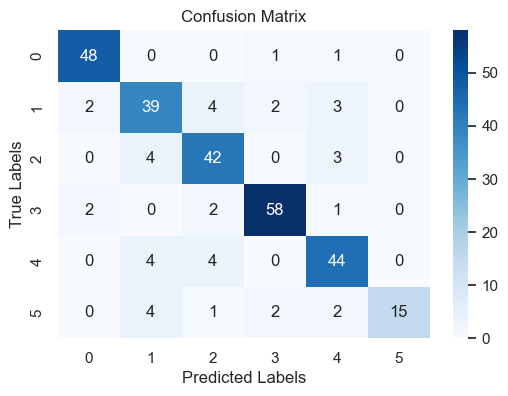

In [61]:
# make predictions using the trained ELM model on the scaled test data
vgg19_pred = vgg19_elm.predict(vgg19_test_scaled)
# use 'np.argmax()' to convert the predictions from one-hot encoded format to class labels
vgg19_pred_labels = np.argmax(vgg19_pred, axis=1)

# calculate the performance metrics - accuracy, precision, recall, f1 score and confusion matrix
accuracy = accuracy_score(vgg19_test_encoded, vgg19_pred_labels)
precision = precision_score(vgg19_test_encoded, vgg19_pred_labels, average='weighted')
recall = recall_score(vgg19_test_encoded, vgg19_pred_labels, average='weighted')
f1 = f1_score(vgg19_test_encoded, vgg19_pred_labels, average='weighted')
conf_matrix = confusion_matrix(vgg19_test_encoded, vgg19_pred_labels)

# print the calculated performance matrix
print("Test Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("F1 Score: {:.2f}%".format(f1 * 100))

# use heatmap to plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

#### MODEL 4 : DENSENET 121-ELM

In [63]:
# create the feature extraction model with DenseNet121 as base model
densenet = create_model(DenseNet121)

In [64]:
# print the summary of model 
densenet.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,037,504 (26.85 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 7,037,504 (26.85 MB)

In [65]:
# use 'extract_features' function to extract the features and corresponding labeles for each subset
densenet_train_features, densenet_train_labels = extract_features(train_dataset, densenet)
densenet_val_features, densenet_val_labels = extract_features(val_dataset, densenet)
densenet_test_features, densenet_test_labels = extract_features(test_dataset, densenet)

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 

In [66]:
# print the shape of features for each subset
print("Train features shape:", densenet_train_features.shape)
print("Validation features shape:", densenet_val_features.shape)
print("Test features shape:", densenet_test_features.shape)

Train features shape: (2015, 1024)
Validation features shape: (224, 1024)
Test features shape: (288, 1024)


In [67]:
# standardize the extracted features
densenet_train_scaled = scaler.fit_transform(densenet_train_features)
densenet_val_scaled = scaler.fit_transform(densenet_val_features)
densenet_test_scaled = scaler.transform(densenet_test_features)

In [68]:
# perform one-hot encoding for labels
densenet_train_encoded, densenet_val_encoded ,densenet_test_encoded, densenet_train_onehot, densenet_val_onehot, densenet_test_onehot = one_hot_encode_labels(densenet_train_labels, densenet_val_labels, densenet_test_labels)


In [69]:
# create the ELM model for densenet features
densenet_elm = create_ELM(densenet_train_scaled.shape[1], densenet_train_onehot.shape[1], 1000, "tanh")
# train the model using 'hpelm.mss_v.train_v' - the function finds the optimized number of neurons for the model 
hpelm.mss_v.train_v(densenet_elm, densenet_train_scaled, densenet_train_onehot, densenet_val_scaled, densenet_val_onehot)

# print the optimal number of neurons used in the model
optimal_neurons = densenet_elm.nnet.L
print("Optimal number of neurons: ", optimal_neurons)

Optimal number of neurons:  812


Test Accuracy: 93.75%
Precision: 93.98%
Recall: 93.75%
F1 Score: 93.76%


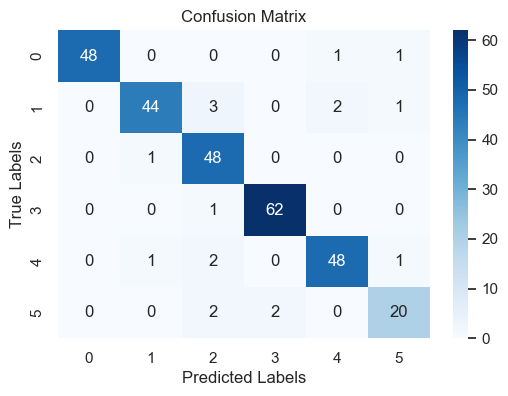

In [70]:
# make predictions using the trained ELM model on the scaled test data
densenet_pred = densenet_elm.predict(densenet_test_scaled)
# use 'np.argmax()' to convert the predictions from one-hot encoded format to class labels
densenet_pred_labels = np.argmax(densenet_pred, axis=1)

# calculate the performance metrics - accuracy, precision, recall, f1 score and confusion matrix
accuracy = accuracy_score(densenet_test_encoded, densenet_pred_labels)
precision = precision_score(densenet_test_encoded, densenet_pred_labels, average='weighted')
recall = recall_score(densenet_test_encoded, densenet_pred_labels, average='weighted')
f1 = f1_score(densenet_test_encoded, densenet_pred_labels, average='weighted')
conf_matrix = confusion_matrix(densenet_test_encoded, densenet_pred_labels)

# print the calculated performance matrix
print("Test Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("F1 Score: {:.2f}%".format(f1 * 100))

# use heatmap to plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

#### MODEL 5 : EFFICIENTNET-ELM

In [72]:
# create the feature extraction model with EfficientNetB0 as base model
efficientnet = create_model(EfficientNetB0)

In [73]:
# print the summary of model
efficientnet.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,049,571 (15.45 MB)

In [74]:
# use 'extract_features' function to extract the features and corresponding labeles for each subset
efficientnet_train_features, efficientnet_train_labels = extract_features(train_dataset, efficientnet)
efficientnet_val_features, efficientnet_val_labels = extract_features(val_dataset, efficientnet)
efficientnet_test_features, efficientnet_test_labels = extract_features(test_dataset, efficientnet)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 685ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 748ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 685ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

In [75]:
# print the shape of features for each subset
print("Train features shape:", efficientnet_train_features.shape)
print("Validation features shape:", efficientnet_val_features.shape)
print("Test features shape:", efficientnet_test_features.shape)

Train features shape: (2015, 1280)
Validation features shape: (224, 1280)
Test features shape: (288, 1280)


In [76]:
# standardize the extracted features
efficientnet_train_scaled = scaler.fit_transform(efficientnet_train_features)
efficientnet_val_scaled = scaler.fit_transform(efficientnet_val_features)
efficientnet_test_scaled = scaler.transform(efficientnet_test_features)

In [77]:
# perform one-hot encoding for labels
efficientnet_train_encoded, efficientnet_val_encoded ,efficientnet_test_encoded, efficientnet_train_onehot, efficientnet_val_onehot, efficientnet_test_onehot = one_hot_encode_labels(efficientnet_train_labels, efficientnet_val_labels, efficientnet_test_labels)


In [78]:
# create the ELM model for efficientnet features
efficientnet_elm = create_ELM(efficientnet_train_scaled.shape[1], efficientnet_train_onehot.shape[1], 1000, "tanh")
# train the model using 'hpelm.mss_v.train_v' - the function finds the optimized number of neurons for the model 
hpelm.mss_v.train_v(efficientnet_elm, efficientnet_train_scaled, efficientnet_train_onehot, efficientnet_val_scaled, efficientnet_val_onehot)

# print the optimal number of neurons used in the model
optimal_neurons = efficientnet_elm.nnet.L
print("Optimal number of neurons: ", optimal_neurons)

Optimal number of neurons:  886


Test Accuracy: 79.51%
Precision: 79.88%
Recall: 79.51%
F1 Score: 79.56%


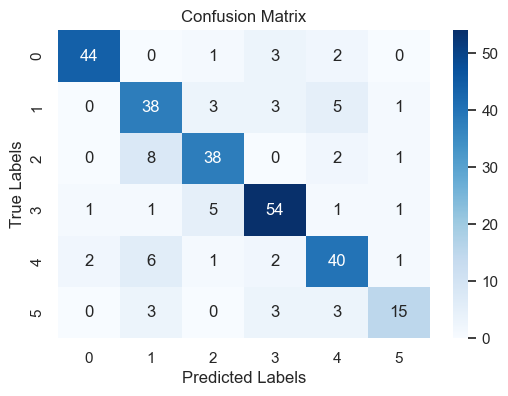

In [79]:
# make predictions using the trained ELM model on the scaled test data
efficientnet_pred = efficientnet_elm.predict(efficientnet_test_scaled)
# use 'np.argmax()' to convert the predictions from one-hot encoded format to class labels
efficientnet_pred_labels = np.argmax(efficientnet_pred, axis=1)

# calculate the performance metrics - accuracy, precision, recall, f1 score and confusion matrix
accuracy = accuracy_score(efficientnet_test_encoded, efficientnet_pred_labels)
precision = precision_score(efficientnet_test_encoded, efficientnet_pred_labels, average='weighted')
recall = recall_score(efficientnet_test_encoded, efficientnet_pred_labels, average='weighted')
f1 = f1_score(efficientnet_test_encoded, efficientnet_pred_labels, average='weighted')
conf_matrix = confusion_matrix(efficientnet_test_encoded, efficientnet_pred_labels)

# print the calculated performance matrix
print("Test Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("F1 Score: {:.2f}%".format(f1 * 100))

# use heatmap to plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

#### ENSEMBLE - VOTING

In [81]:
# initialize an empty list to store predictions from different models
predictions = []

# append predictions from different pre-trained models to the list
predictions.append(resnet_pred)
predictions.append(inception_pred)
predictions.append(vgg19_pred)
predictions.append(densenet_pred)
predictions.append(efficientnet_pred)

# calculate the ensemble prediction by summing the predictions from all models and then taking the class with the highest score
# np.sum(predictions, axis=0) aggregates the predictions across all models
# np.argmax(..., axis=1) finds the class label with the highest score for each sample
ensemble_pred = np.argmax(np.sum(predictions, axis=0), axis=1)

# print the summed predictions to see the aggregated scores
np.sum(predictions, axis=0)

array([[-0.31114771, -0.08628062,  1.05574883,  0.8259031 ,  0.10616864,
         3.50417191],
       [-0.21026489,  0.26422762,  0.77868081,  0.46032436,  1.26868896,
         1.95898505],
       [ 0.21224598,  4.40830794,  0.01654819, -0.10924741,  0.01850929,
         0.43972131],
       ...,
       [-0.2389856 ,  2.23283443,  3.20840043, -3.34233285,  2.78699448,
        -0.69867565],
       [ 1.71792433, -0.35911909,  0.56399701,  0.86567681,  0.40319556,
         1.59183057],
       [-1.95607711,  0.99768368,  4.18113655,  0.92472278, -0.03636918,
         0.16948291]])

Test Accuracy: 94.79%
Precision: 95.13%
Recall: 94.79%
F1 Score: 94.78%


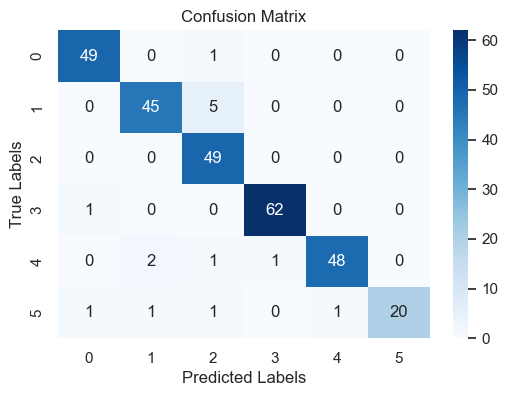

In [82]:
# calculate the performance metrics - accuracy, precision, recall, f1 score and confusion matrix
accuracy = accuracy_score(efficientnet_test_encoded, ensemble_pred)
precision = precision_score(efficientnet_test_encoded, ensemble_pred, average='weighted')
recall = recall_score(efficientnet_test_encoded, ensemble_pred, average='weighted')
f1 = f1_score(efficientnet_test_encoded, ensemble_pred, average='weighted')
conf_matrix = confusion_matrix(efficientnet_test_encoded, ensemble_pred)

# print the calculated performance matrix
print("Test Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("F1 Score: {:.2f}%".format(f1 * 100))

# use heatmap to plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### WITH AUGMENTATION

#### MODEL 1: RESNET50-ELM

In [85]:
# use 'extract_features' function to extract the features and corresponding labeles for each subset
resnet_train_features, resnet_train_labels = extract_features(augmented_train_dataset, resnet)
resnet_val_features, resnet_val_labels = extract_features(val_dataset, resnet)
resnet_test_features, resnet_test_labels = extract_features(test_dataset, resnet)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 

In [86]:
# print the shape of features for each subset
print("Train features shape:", resnet_train_features.shape)
print("Validation features shape:", resnet_val_features.shape)
print("Test features shape:", resnet_test_features.shape)

Train features shape: (2015, 2048)
Validation features shape: (224, 2048)
Test features shape: (288, 2048)


In [87]:
# standardize the extracted features
resnet_train_scaled = scaler.fit_transform(resnet_train_features)
resnet_val_scaled = scaler.fit_transform(resnet_val_features)
resnet_test_scaled = scaler.transform(resnet_test_features)

In [88]:
# perform one-hot encoding for labels
resnet_train_encoded, resnet_val_encoded ,resnet_test_encoded, resnet_train_onehot, resnet_val_onehot, resnet_test_onehot = one_hot_encode_labels(resnet_train_labels, resnet_val_labels, resnet_test_labels)


In [89]:
# create the ELM model for resnet features
resnet_elm = create_ELM(resnet_train_scaled.shape[1], resnet_train_onehot.shape[1], 1000, "tanh")
# train the model using 'hpelm.mss_v.train_v' - the function finds the optimized number of neurons for the model 
hpelm.mss_v.train_v(resnet_elm, resnet_train_scaled, resnet_train_onehot, resnet_val_scaled, resnet_val_onehot)

# print the optimal number of neurons used in the model
optimal_neurons = resnet_elm.nnet.L
print("Optimal number of neurons: ", optimal_neurons)

Optimal number of neurons:  750


Test Accuracy: 32.29%
Precision: 31.46%
Recall: 32.29%
F1 Score: 31.68%


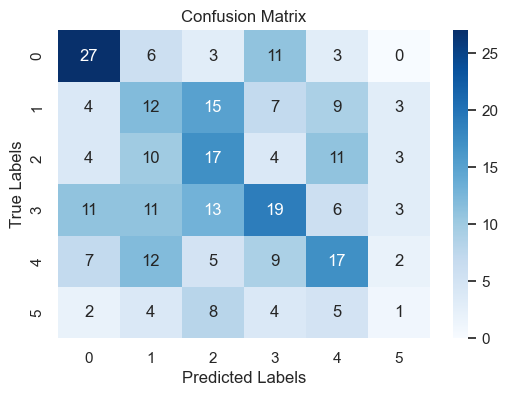

In [90]:
# make predictions using the trained ELM model on the scaled test data
resnet_pred = resnet_elm.predict(resnet_test_scaled)
# use 'np.argmax()' to convert the predictions from one-hot encoded format to class labels
resnet_pred_labels = np.argmax(resnet_pred, axis=1)

# calculate the performance metrics - accuracy, precision, recall, f1 score and confusion matrix
accuracy = accuracy_score(resnet_test_encoded, resnet_pred_labels)
precision = precision_score(resnet_test_encoded, resnet_pred_labels, average='weighted')
recall = recall_score(resnet_test_encoded, resnet_pred_labels, average='weighted')
f1 = f1_score(resnet_test_encoded, resnet_pred_labels, average='weighted')
conf_matrix = confusion_matrix(resnet_test_encoded, resnet_pred_labels)

# print the calculated performance matrix
print("Test Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("F1 Score: {:.2f}%".format(f1 * 100))

# use heatmap to plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

#### MODEL 2: INCEPTION V3-ELM

In [92]:
# use 'extract_features' function to extract the features and corresponding labeles for each subset
inception_train_features, inception_train_labels = extract_features(augmented_train_dataset, inception)
inception_val_features, inception_val_labels = extract_features(val_dataset, inception)
inception_test_features, inception_test_labels = extract_features(test_dataset, inception)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

In [93]:
# print the shape of features for each subset
print("Train features shape:", inception_train_features.shape)
print("Validation features shape:", inception_val_features.shape)
print("Test features shape:", inception_test_features.shape)

Train features shape: (2015, 2048)
Validation features shape: (224, 2048)
Test features shape: (288, 2048)


In [94]:
# standardize the extracted features
inception_train_scaled = scaler.fit_transform(inception_train_features)
inception_val_scaled = scaler.fit_transform(inception_val_features)
inception_test_scaled = scaler.transform(inception_test_features)

In [95]:
# perform one-hot encoding for labels
inception_train_encoded, inception_val_encoded ,inception_test_encoded, inception_train_onehot, inception_val_onehot, inception_test_onehot = one_hot_encode_labels(inception_train_labels, inception_val_labels, inception_test_labels)


In [96]:
# create the ELM model for inception features
inception_elm = create_ELM(inception_train_scaled.shape[1], inception_train_onehot.shape[1], 1000, "tanh")
# train the model using 'hpelm.mss_v.train_v' - the function finds the optimized number of neurons for the model 
hpelm.mss_v.train_v(inception_elm, inception_train_scaled, inception_train_onehot, inception_val_scaled, inception_val_onehot)

# print the optimal number of neurons used in the model
optimal_neurons = inception_elm.nnet.L
print("Optimal number of neurons: ", optimal_neurons)

Optimal number of neurons:  427


Test Accuracy: 72.92%
Precision: 75.62%
Recall: 72.92%
F1 Score: 71.95%


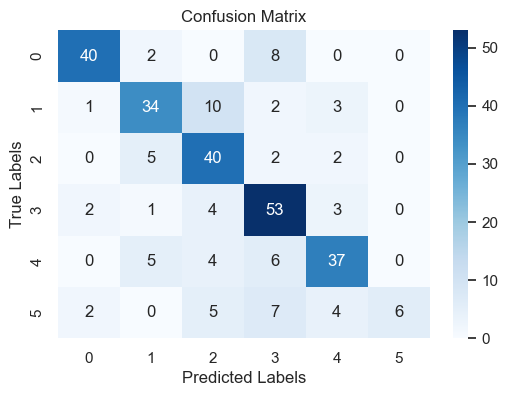

In [97]:
# make predictions using the trained ELM model on the scaled test data
inception_pred = inception_elm.predict(inception_test_scaled)
# use 'np.argmax()' to convert the predictions from one-hot encoded format to class labels
inception_pred_labels = np.argmax(inception_pred, axis=1)

# calculate the performance metrics - accuracy, precision, recall, f1 score and confusion matrix
accuracy = accuracy_score(inception_test_encoded, inception_pred_labels)
precision = precision_score(inception_test_encoded, inception_pred_labels, average='weighted')
recall = recall_score(inception_test_encoded, inception_pred_labels, average='weighted')
f1 = f1_score(inception_test_encoded, inception_pred_labels, average='weighted')
conf_matrix = confusion_matrix(inception_test_encoded, inception_pred_labels)

# print the calculated performance matrix
print("Test Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("F1 Score: {:.2f}%".format(f1 * 100))

# use heatmap to plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

#### MODEL 3: VGG19-ELM

In [99]:
# use 'extract_features' function to extract the features and corresponding labeles for each subset
vgg19_train_features, vgg19_train_labels = extract_features(augmented_train_dataset, vgg19)
vgg19_val_features, vgg19_val_labels = extract_features(val_dataset, vgg19)
vgg19_test_features, vgg19_test_labels = extract_features(test_dataset, vgg19)

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 

In [100]:
# print the shape of features for each subset
print("Train features shape:", vgg19_train_features.shape)
print("Validation features shape:", vgg19_val_features.shape)
print("Test features shape:", vgg19_test_features.shape)

Train features shape: (2015, 512)
Validation features shape: (224, 512)
Test features shape: (288, 512)


In [101]:
# standardize the extracted features
vgg19_train_scaled = scaler.fit_transform(vgg19_train_features)
vgg19_val_scaled = scaler.fit_transform(vgg19_val_features)
vgg19_test_scaled = scaler.transform(vgg19_test_features)

In [102]:
# perform one-hot encoding for labels
vgg19_train_encoded, vgg19_val_encoded ,vgg19_test_encoded, vgg19_train_onehot, vgg19_val_onehot, vgg19_test_onehot = one_hot_encode_labels(vgg19_train_labels, vgg19_val_labels, vgg19_test_labels)


In [103]:
# create the ELM model for vgg19 features
vgg19_elm = create_ELM(vgg19_train_scaled.shape[1], vgg19_train_onehot.shape[1], 1000, "tanh")
# train the model using 'hpelm.mss_v.train_v' - the function finds the optimized number of neurons for the model 
hpelm.mss_v.train_v(vgg19_elm, vgg19_train_scaled, vgg19_train_onehot, vgg19_val_scaled, vgg19_val_onehot)

# print the optimal number of neurons used in the model
optimal_neurons = vgg19_elm.nnet.L
print("Optimal number of neurons: ", optimal_neurons)

Optimal number of neurons:  362


Test Accuracy: 65.62%
Precision: 66.05%
Recall: 65.62%
F1 Score: 64.34%


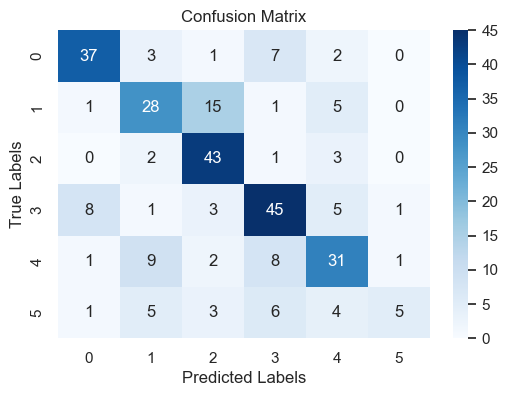

In [104]:
# make predictions using the trained ELM model on the scaled test data
vgg19_pred = vgg19_elm.predict(vgg19_test_scaled)
# use 'np.argmax()' to convert the predictions from one-hot encoded format to class labels
vgg19_pred_labels = np.argmax(vgg19_pred, axis=1)

# calculate the performance metrics - accuracy, precision, recall, f1 score and confusion matrix
accuracy = accuracy_score(vgg19_test_encoded, vgg19_pred_labels)
precision = precision_score(vgg19_test_encoded, vgg19_pred_labels, average='weighted')
recall = recall_score(vgg19_test_encoded, vgg19_pred_labels, average='weighted')
f1 = f1_score(vgg19_test_encoded, vgg19_pred_labels, average='weighted')
conf_matrix = confusion_matrix(vgg19_test_encoded, vgg19_pred_labels)

# print the calculated performance matrix
print("Test Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("F1 Score: {:.2f}%".format(f1 * 100))

# use heatmap to plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

#### MODEL 4 : DENSENET121-ELM

In [106]:
# use 'extract_features' function to extract the features and corresponding labeles for each subset
densenet_train_features, densenet_train_labels = extract_features(augmented_train_dataset, densenet)
densenet_val_features, densenet_val_labels = extract_features(val_dataset, densenet)
densenet_test_features, densenet_test_labels = extract_features(test_dataset, densenet)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 

In [107]:
# print the shape of features for each subset
print("Train features shape:", densenet_train_features.shape)
print("Validation features shape:", densenet_val_features.shape)
print("Test features shape:", densenet_test_features.shape)

Train features shape: (2015, 1024)
Validation features shape: (224, 1024)
Test features shape: (288, 1024)


In [108]:
# standardize the extracted features
densenet_train_scaled = scaler.fit_transform(densenet_train_features)
densenet_val_scaled = scaler.fit_transform(densenet_val_features)
densenet_test_scaled = scaler.transform(densenet_test_features)

In [109]:
# perform one-hot encoding for labels
densenet_train_encoded, densenet_val_encoded ,densenet_test_encoded, densenet_train_onehot, densenet_val_onehot, densenet_test_onehot = one_hot_encode_labels(densenet_train_labels, densenet_val_labels, densenet_test_labels)


In [110]:
# create the ELM model for densenet features
densenet_elm = create_ELM(densenet_train_scaled.shape[1], densenet_train_onehot.shape[1], 1000, "tanh")
# train the model using 'hpelm.mss_v.train_v' - the function finds the optimized number of neurons for the model 
hpelm.mss_v.train_v(densenet_elm, densenet_train_scaled, densenet_train_onehot, densenet_val_scaled, densenet_val_onehot)

# print the optimal number of neurons used in the model
optimal_neurons = densenet_elm.nnet.L
print("Optimal number of neurons: ", optimal_neurons)

Optimal number of neurons:  684


Test Accuracy: 79.51%
Precision: 79.99%
Recall: 79.51%
F1 Score: 79.50%


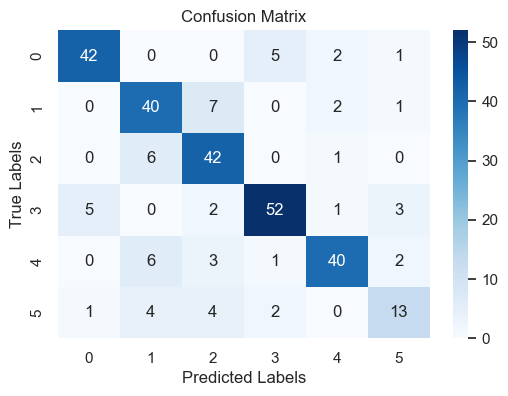

In [111]:
# make predictions using the trained ELM model on the scaled test data
densenet_pred = densenet_elm.predict(densenet_test_scaled)
# use 'np.argmax()' to convert the predictions from one-hot encoded format to class labels
densenet_pred_labels = np.argmax(densenet_pred, axis=1)

# calculate the performance metrics - accuracy, precision, recall, f1 score and confusion matrix
accuracy = accuracy_score(densenet_test_encoded, densenet_pred_labels)
precision = precision_score(densenet_test_encoded, densenet_pred_labels, average='weighted')
recall = recall_score(densenet_test_encoded, densenet_pred_labels, average='weighted')
f1 = f1_score(densenet_test_encoded, densenet_pred_labels, average='weighted')
conf_matrix = confusion_matrix(densenet_test_encoded, densenet_pred_labels)

# print the calculated performance matrix
print("Test Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("F1 Score: {:.2f}%".format(f1 * 100))

# use heatmap to plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

#### MODEL 5 : EFFICIENTNET-ELM

In [113]:
# use 'extract_features' function to extract the features and corresponding labeles for each subset
efficientnet_train_features, efficientnet_train_labels = extract_features(augmented_train_dataset, efficientnet)
efficientnet_val_features, efficientnet_val_labels = extract_features(val_dataset, efficientnet)
efficientnet_test_features, efficientnet_test_labels = extract_features(test_dataset, efficientnet)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 782ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 977ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 979ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 855ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 808ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [114]:
# print the shape of features for each subset
print("Train features shape:", efficientnet_train_features.shape)
print("Validation features shape:", efficientnet_val_features.shape)
print("Test features shape:", efficientnet_test_features.shape)

Train features shape: (2015, 1280)
Validation features shape: (224, 1280)
Test features shape: (288, 1280)


In [115]:
# standardize the extracted features
efficientnet_train_scaled = scaler.fit_transform(efficientnet_train_features)
efficientnet_val_scaled = scaler.fit_transform(efficientnet_val_features)
efficientnet_test_scaled = scaler.transform(efficientnet_test_features)

In [116]:
# perform one-hot encoding for labels
efficientnet_train_encoded, efficientnet_val_encoded ,efficientnet_test_encoded, efficientnet_train_onehot, efficientnet_val_onehot, efficientnet_test_onehot = one_hot_encode_labels(efficientnet_train_labels, efficientnet_val_labels, efficientnet_test_labels)


In [117]:
# create the ELM model for efficientnet features
efficientnet_elm = create_ELM(efficientnet_train_scaled.shape[1], efficientnet_train_onehot.shape[1], 1000, "tanh")
# train the model using 'hpelm.mss_v.train_v' - the function finds the optimized number of neurons for the model 
hpelm.mss_v.train_v(efficientnet_elm, efficientnet_train_scaled, efficientnet_train_onehot, efficientnet_val_scaled, efficientnet_val_onehot)

# print the optimal number of neurons used in the model
optimal_neurons = efficientnet_elm.nnet.L
print("Optimal number of neurons: ", optimal_neurons)

Optimal number of neurons:  375


Test Accuracy: 45.14%
Precision: 46.49%
Recall: 45.14%
F1 Score: 44.87%


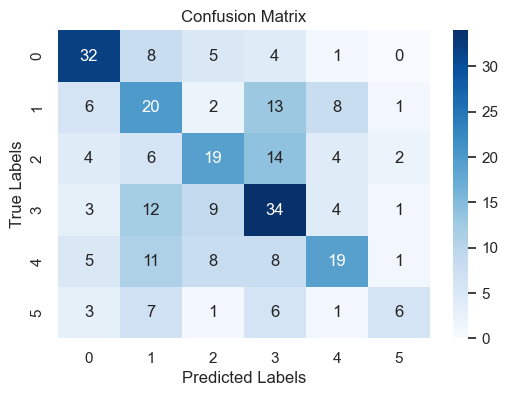

In [118]:
# make predictions using the trained ELM model on the scaled test data
efficientnet_pred = efficientnet_elm.predict(efficientnet_test_scaled)
# use 'np.argmax()' to convert the predictions from one-hot encoded format to class labels
efficientnet_pred_labels = np.argmax(efficientnet_pred, axis=1)

# calculate the performance metrics - accuracy, precision, recall, f1 score and confusion matrix
accuracy = accuracy_score(efficientnet_test_encoded, efficientnet_pred_labels)
precision = precision_score(efficientnet_test_encoded, efficientnet_pred_labels, average='weighted')
recall = recall_score(efficientnet_test_encoded, efficientnet_pred_labels, average='weighted')
f1 = f1_score(efficientnet_test_encoded, efficientnet_pred_labels, average='weighted')
conf_matrix = confusion_matrix(efficientnet_test_encoded, efficientnet_pred_labels)

# print the calculated performance matrix
print("Test Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("F1 Score: {:.2f}%".format(f1 * 100))

# use heatmap to plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### ENSEMBLE

In [120]:
# initialize an empty list to store predictions from different models
predictions = []

# append predictions from different pre-trained models to the list
predictions.append(resnet_pred)
predictions.append(inception_pred)
predictions.append(vgg19_pred)
predictions.append(densenet_pred)
predictions.append(efficientnet_pred)

# calculate the ensemble prediction by summing the predictions from all models and then taking the class with the highest score
# np.sum(predictions, axis=0) aggregates the predictions across all models
# np.argmax(..., axis=1) finds the class label with the highest score for each sample
ensemble_pred = np.argmax(np.sum(predictions, axis=0), axis=1)

# print the summed predictions to see the aggregated scores
np.sum(predictions, axis=0)

array([[-0.15682003,  0.45260968,  2.62608308,  1.02733369, -0.21702279,
         1.43088482],
       [-0.0459505 ,  0.62014272,  1.74054754, -0.60626463,  2.15106363,
         1.11975828],
       [ 0.42415307,  3.38844186,  0.57459279, -0.2942847 , -0.01790002,
         0.2992533 ],
       ...,
       [ 0.76626831,  3.76275525, -0.40689153,  1.11047267, -1.36121343,
         0.3774732 ],
       [ 2.5080433 ,  0.89945261,  0.33377174,  0.81177331, -0.09481421,
         0.44060402],
       [ 0.19653333, -0.59229255,  4.76857243,  0.63995694, -1.28386981,
         0.45122345]])

Test Accuracy: 76.04%
Precision: 78.22%
Recall: 76.04%
F1 Score: 75.73%


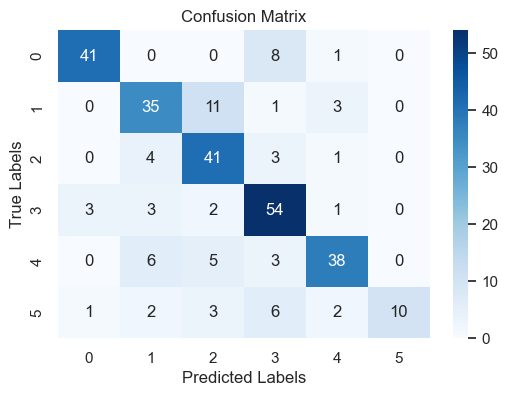

In [121]:
# calculate the performance metrics - accuracy, precision, recall, f1 score and confusion matrix
accuracy = accuracy_score(efficientnet_test_encoded, ensemble_pred)
precision = precision_score(efficientnet_test_encoded, ensemble_pred, average='weighted')
recall = recall_score(efficientnet_test_encoded, ensemble_pred, average='weighted')
f1 = f1_score(efficientnet_test_encoded, ensemble_pred, average='weighted')
conf_matrix = confusion_matrix(efficientnet_test_encoded, ensemble_pred)

# print the calculated performance matrix
print("Test Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("F1 Score: {:.2f}%".format(f1 * 100))

# use heatmap to plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()